# Sobre el dataset

El Dataset de **Elegibilidad para tarjetas de crédito** reúne una serie de variables que buscan identificar los factores que influyen en la elegibilidad de una persona para obtener una tarjeta de crédito.  
Incluye datos demográficos, financieros y personales de cada individuo, como género, edad, ingresos, estado de empleo, estado familiar, tipo de vivienda, nivel educativo y ocupación. Cada individuo está representado por un ID único, y el conjunto de datos ofrece una visión completa de sus antecedentes y circunstancias.  

**Objetivo Principal:**  
Desarrollar un modelo de machine learning capaz de predecir la elegibilidad de un individuo para obtener una tarjeta de crédito, utilizando atributos demográficos, financieros y personales.

### Descripción de las columnas:
**1. Account_length:** La duración de la cuenta del cliente con un banco o institución financiera.  
**2. Total_income:** El ingreso total del cliente.  
**3. Age:** La edad del cliente.  
**4. Years_employed:** El número de años que el cliente ha estado empleado.  
**5. Target:** La variable objetivo para la tarea de clasificación, que indica si el cliente es elegible para una tarjeta de crédito o no (por ejemplo, Sí/No, 1/0).  

# Indíce
**1- Importar librerias**  
**2- Cargar y examinar los datos**  
**3- Sampling**
**4- Split de los datos**  
**5- Transformación y Estandarizacion de las variables**  
**6- Inmplemetación del modelo**  
**7- Guardar el modelo**

#### 1. Importar librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import probplot
import random
import warnings
warnings.filterwarnings("ignore")

# Data Sampling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

# Model Selection
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

Configuracion de las visualizaciones

In [2]:
# Cambiar el color de fondo de plt
plt.rcParams['figure.facecolor'] = '#363636'
plt.rcParams['axes.facecolor'] = '#363636'
plt.rcParams['axes.edgecolor'] = '#FFFFFF'
# plt.rcParams['ax']

In [3]:
os.chdir('..')

#### 2. Cargar y examinar los datos

In [4]:
df= pd.read_csv('data/processed/dataset_ML.csv', sep=',')
# df= pd.read_csv('data/raw/dataset.csv', sep=',')

In [5]:
df.head()

,Family_status,Unemployed,Own_property,Account_length,Age,Total_income,Years_employed,Target
0,Civil marriage,0,1,15,32.868574,157500.0,12.435574,1
1,Married,0,1,29,58.793815,112500.0,3.104787,0
2,Single / not married,0,1,4,52.321403,270000.0,8.353354,0
3,Separated,1,1,20,61.504343,283500.0,0.000000,0
4,Married,0,1,5,46.193967,270000.0,2.105450,0


Vamos a vizualizar la distribución de las variables para saber que tipo de transformación debemos aplicar.

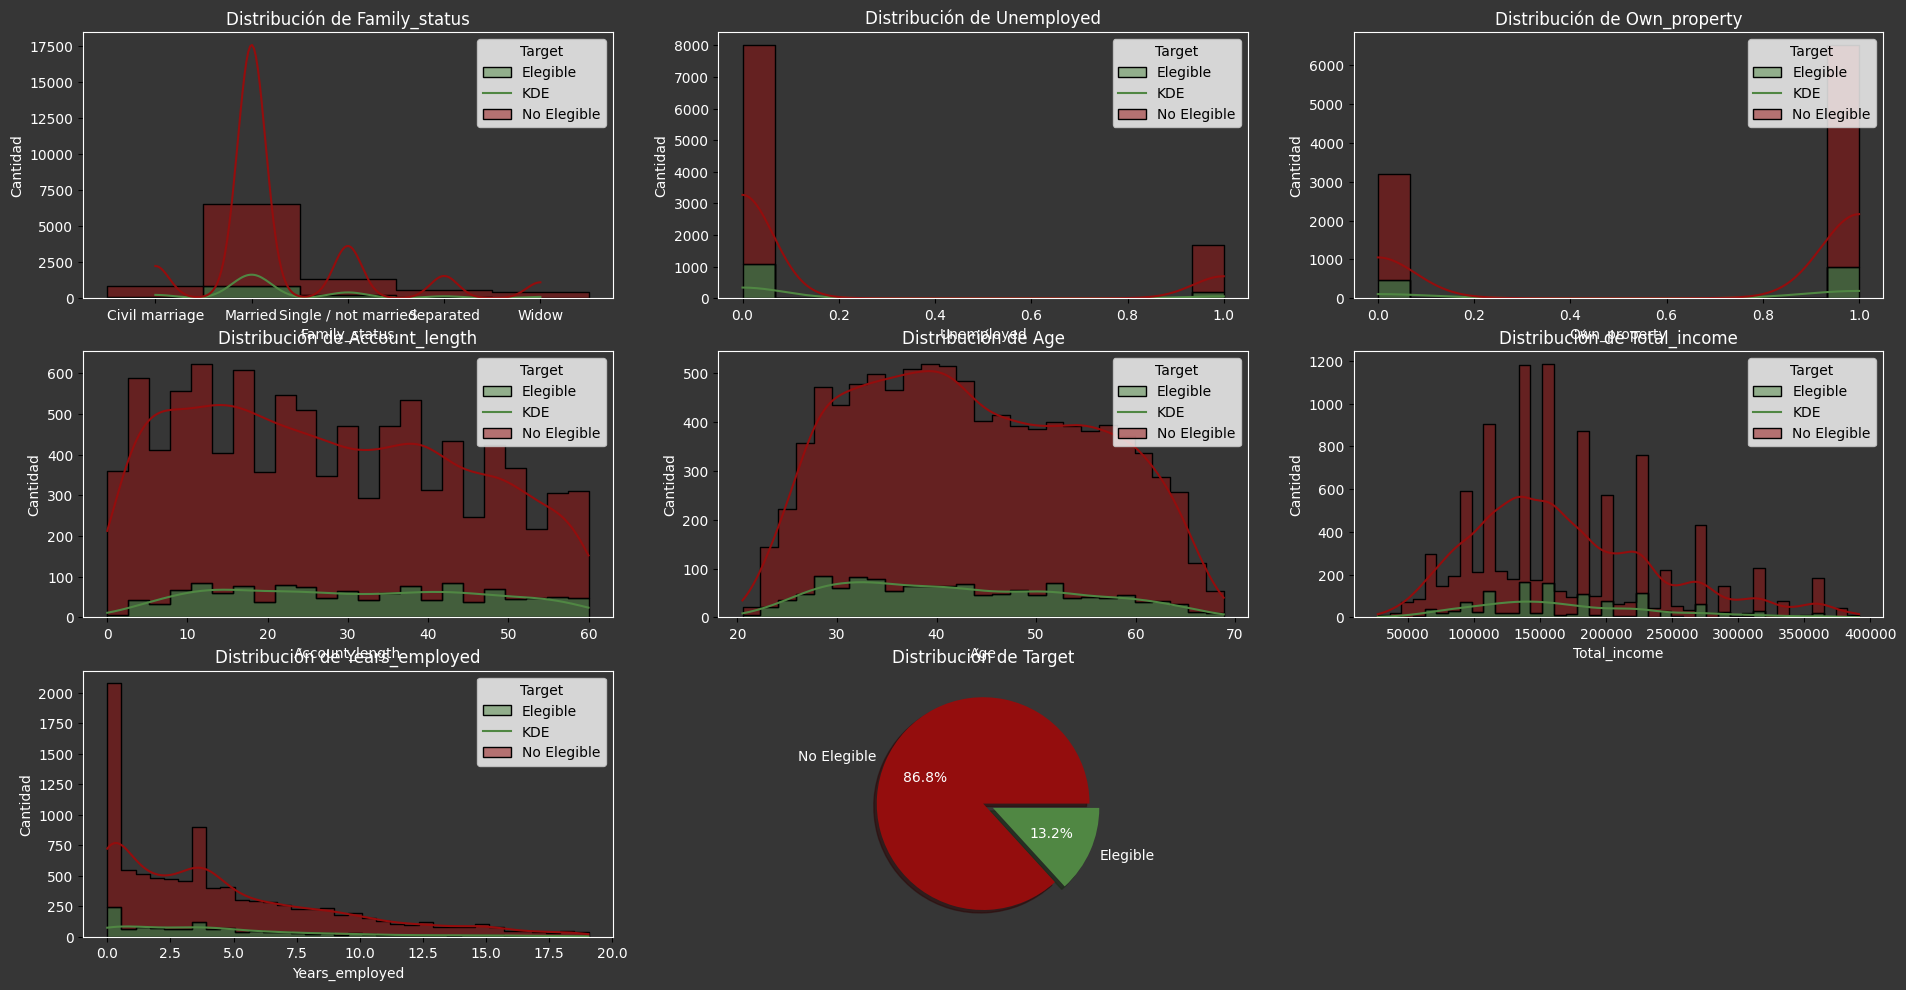

In [6]:
plt.figure(figsize=(60, 25))
for i,column in enumerate(df.columns):
    plt.subplot(len(df.columns),3,i+1)
    plt.subplots_adjust(left=0.7, right=1, top=2, bottom=1)
    if column == 'Target':
        plt.pie(df['Target'].value_counts(), 
                labels=['No Elegible','Elegible'], 
                autopct='%1.1f%%', 
                colors=['#940D0D','#508743'],
                textprops={'color':'white'},
                shadow=True,
                explode=(0,0.1))
        plt.title('Distribución de Target', color='white')
        
    else:
        sns.histplot(data=df,
                    x=column, 
                    hue=df['Target'],
                    palette=['#940D0D','#508743'],
                    kde=True,
                    multiple='stack',
                    element='step',)
        plt.xticks(color='white')
        plt.yticks(color='white')
        plt.legend(title='Target', loc='upper right', facecolor='white', labels=['Elegible','KDE', 'No Elegible'])
        plt.title(f'Distribución de {column}', color='white')
        plt.ylabel('Cantidad', color='white')
        plt.xlabel(column, color='white')
plt.show()

**'Years_employed'** tienen una distribución sesgada a la derecha mayormente presenta los valores en 0 vamos a aplicar una transformacion binomial  
**'Total_income'** tiene una distribución con un pequeño sesgo a la derecha vamos a aplicar una transformación raíz cuadrada para reducir el sesgo.  
**'Age'** y **'Account_length'** tiene una distribución bastante uniforme, asi que solo vamos a estandarizarlas.  
**'Target'** la variable objetivo, tiene un desbalance, vamos a aplicar a tecnicas de sampling para balancearla.

#### 3. Sampling

Separamos la variable objetivo de las variables predictoras y aplicamos tecnicas de sampling para balancear la variable objetivo.

In [7]:
#variables
X = df.drop('Target', axis=1)
# Target variable
y = df['Target']  # Target variable

Para balancear la variable objetivo vamos a aplicar la técnica de **SMOTE**. el cual es un algoritmo que genera muestras sintéticas de la clase minoritaria.

In [9]:
smote = SMOTE( random_state=42)
X_res, y_res = smote.fit_resample(X,y)

ValueError: could not convert string to float: 'Civil marriage'

Text(0.5, 1.0, 'Distribución de Target')

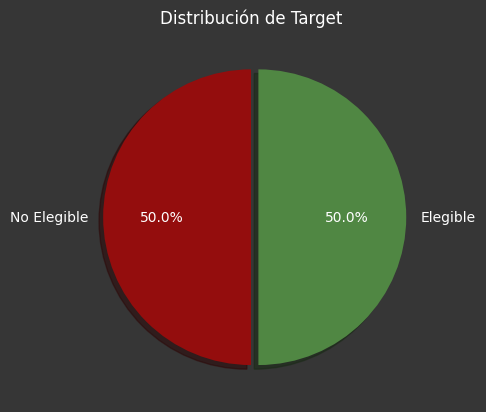

In [10]:
plt.pie(y_res.value_counts(), 
                labels=['No Elegible','Elegible'], 
                autopct='%1.1f%%', 
                colors=['#940D0D','#508743'],
                textprops={'color':'white'},
                shadow=True,
                startangle=90,
                explode=(0,0.05))
plt.title('Distribución de Target', color='white')

Ya con los datos balanceados vamos a aplicar el split de los datos.

#### 4. Split de los datos

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Account_length,9709.0,27.270059,16.648057,0.000000,13.000000,26.000000,41.000000,60.000000
Age,9709.0,43.784093,11.625768,20.504186,34.059563,42.741466,53.567151,68.863837
Total_income,9709.0,169247.746163,71153.890318,27000.000000,112500.000000,157500.000000,208350.000000,391500.000000
Years_employed,9709.0,4.633885,4.448404,0.000000,0.928150,3.761884,7.011780,19.053095
Target,9709.0,0.132145,0.338666,0.000000,0.000000,0.000000,0.000000,1.000000


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

#### 5. Transformación y Estandarizacion de las variables

Vamos a crear un Pipeline con los siguientes pasos:
1. Escalado de las variables **Age** y **Account_length**  
2. Transformación yeo-jhonson de la variable **Years_employed**  
3. Transformación raíz cuadrada de la variable **Total_income**

In [12]:
# Definir las columnas que deseas transformar
columns_to_transform = ['Account_length', 'Age']

# Crear el objeto ColumnTransformer
column_transformer = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(),['Account_length', 'Age']),
                ('sqrt', FunctionTransformer(np.sqrt), ['Total_income']),
                ('yeo-johnson', PowerTransformer(method='yeo-johnson'), ['Years_employed']),
                ('onehot', OneHotEncoder(drop='first'), ['Family_status', 'Unemployed', 'Own_property'])
            ])


#### 6. Inmplemetación del modelo

Vamos a probar diferentes modelos de clasificación, probando con diferentes hiperparametros y seleccionando el mejor modelo haciendo una validacion cruzada para asi garantizar que no estamos sobreajustando el modelo.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline

def evaluate_models(X_train, y_train, X_test, y_test):
    # Define the models to evaluate
    models = {
        'Logistic Regression': (LogisticRegression(class_weight='balanced', random_state=42), {
            'max_iter': [1000, 2000, 3000],
            'C': [0.01, 0.1, 1, 10, 100]
        }),
        'Random Forest': (RandomForestClassifier(class_weight='balanced', random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None]
        }),
        'Extra Random Forest': (ExtraTreesClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None]
        }),
        'XGBClassifier': (XGBClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        'Gradient Boosting': (GradientBoostingClassifier(random_state=42), {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 4, 5],
            'learning_rate': [0.01, 0.1, 0.2]
        }),
        'K-Nearest Neighbors': (KNeighborsClassifier(), {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }),
    }

    # Function to evaluate the models with GridSearchCV
    best_model = None
    best_score = 0
    
    for name, (model, params) in models.items():
        # Crear un pipeline que incluya el preprocesador y el modelo
        pipeline = Pipeline([
            ('preprocessor', column_transformer),
            ('classifier', model)
        ])
        grid_search = GridSearchCV(model, params, scoring='f1', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        y_pred = best_estimator.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        print(f"{name} - F1 Score: {f1}")
        if f1 > best_score:
            best_score = f1
            best_model = best_estimator

    return best_model, best_score


In [14]:
# Evaluate the models
best_model, best_score = evaluate_models(X_train, y_train, X_test, y_test)
print(f"Mejor modelo: {best_model} con f1_score: {best_score}")

# print the classification report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
# Imprimir el F1-score
f1 = f1_score(y_test, y_pred)

Logistic Regression - F1 Score: 0.5516304347826086
Random Forest - F1 Score: 0.7619569185834246
Extra Random Forest - F1 Score: 0.7853302611367128
XGBClassifier - F1 Score: 0.7503327628826774
Gradient Boosting - F1 Score: 0.7191629955947136
K-Nearest Neighbors - F1 Score: 0.8031666066930551
Mejor modelo: KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance') con f1_score: 0.8031666066930551
              precision    recall  f1-score   support

           0       0.85      0.68      0.76      2528
           1       0.74      0.88      0.80      2528

    accuracy                           0.78      5056
   macro avg       0.80      0.78      0.78      5056
weighted avg       0.80      0.78      0.78      5056



#### 7. Guardar el modelo

In [16]:
joblib.dump(best_model, f"{os.getcwd()}/model/best_model.joblib")

['c:\\Users\\danie\\Desktop\\Bootcamp_Data\\Github\\c19-129-t-data-bi/model/best_model.joblib']

In [21]:
df.iloc[10]

Account_length        39.000000
Age                   32.422295
Total_income      157500.000000
Years_employed         5.519621
Target                 0.000000
Name: 10, dtype: float64

In [34]:
prueba = pd.DataFrame(df.iloc[1:10].T)

In [35]:
prueba.T

,Account_length,Age,Total_income,Years_employed,Target
1,29.0,58.793815,112500.0,3.104787,0.0
2,4.0,52.321403,270000.0,8.353354,0.0
3,20.0,61.504343,283500.0,0.000000,0.0
4,5.0,46.193967,270000.0,2.105450,0.0
5,17.0,48.674511,135000.0,3.269061,0.0
6,25.0,29.210730,130500.0,3.019911,1.0
7,31.0,27.463945,157500.0,4.021985,1.0
8,44.0,30.029364,112500.0,4.435409,0.0
9,24.0,34.741302,270000.0,3.184186,0.0


In [36]:
best_model.predict(prueba.drop('Target').T)

array([0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)